In [4]:
# If needed:
# !pip install statsmodels

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

PROCESSED_DIR = "data/processed"
REPORT_TBLS   = "reports/tables"
REPORT_FIGS   = "reports/figures"
os.makedirs(REPORT_TBLS, exist_ok=True)
os.makedirs(REPORT_FIGS, exist_ok=True)

# Set working directory 

os.chdir("C:\\Users\\yonas\\Documents\\ICPAC\\ea_seasonal_pred\\seasonal-ml-pred")


In [5]:
data_uganda_ond = pd.read_csv("data/processed/uganda_OND_target_features_1981_2024.csv", parse_dates=["season_year"])
data_uganda_ond.set_index("season_year", inplace=True)


data_uganda_ond.head()

,OND_total_mm,OND_clim1991_2020_mm,OND_anom_mm,OND_anom_std,n12_JAS,n12_AS,n12_Sep,n3_JAS,n3_AS,n3_Sep,...,pacwarmpool_Sep,censo_JAS,censo_AS,censo_Sep,dmi_JAS,dmi_AS,dmi_Sep,PERSIST_MJJ_anom_mm,PERSIST_JJA_anom_mm,PERSIST_JAS_anom_mm
season_year,,,,,,,,,,,,,,,,,,,,,
1981-01-01,251.31606,328.4043,-77.088240,-1.053309,-0.936667,-0.960,-0.79,-0.520000,-0.480,-0.23,...,-0.186,-0.360000,-0.235,-0.18,-0.648333,-0.6925,-0.757,-2.042121,1.513391,3.086952
1982-01-01,373.33360,328.4043,44.929290,0.613899,0.860000,1.055,1.31,1.083333,1.420,1.89,...,-0.495,1.786667,1.905,1.95,0.321000,0.3490,0.442,-8.787225,-1.924204,-5.021202
1983-01-01,269.18472,328.4043,-59.219574,-0.809157,2.700000,2.150,1.37,0.526667,0.390,0.13,...,-0.082,-0.070000,-0.285,-0.64,0.267000,0.1380,-0.069,-0.441927,2.636551,2.906827
1984-01-01,294.98053,328.4043,-33.423767,-0.456691,-0.420000,-0.315,-0.07,-0.510000,-0.375,-0.34,...,-0.288,-0.250000,-0.265,-0.21,-0.490667,-0.5530,-0.608,-10.111957,-6.647986,-6.963177
1985-01-01,262.54230,328.4043,-65.862000,-0.899917,-1.206667,-1.110,-0.99,-0.946667,-0.870,-0.86,...,-0.381,-0.390000,-0.460,-0.28,-0.366667,-0.3485,-0.238,-4.830346,0.538307,1.014789


In [6]:
def load_model_table(parq: str, csv: str):
    p = os.path.join(PROCESSED_DIR, parq)
    c = os.path.join(PROCESSED_DIR, csv)
    if os.path.exists(p):
        df = pd.read_parquet(p)
    elif os.path.exists(c):
        df = pd.read_csv(c, index_col=0)
    else:
        raise FileNotFoundError(f"Missing {p} or {c}")
    # year index
    if isinstance(df.index, pd.DatetimeIndex):
        df.index = df.index.year
    else:
        try: df.index = df.index.astype(int)
        except: df.index = pd.to_datetime(df.index, errors="coerce").year.astype(int)
    df.index.name = "season_year"
    return df.sort_index()

# load the csv data only  
OND = data_uganda_ond

OND_target_cols = ["OND_total_mm", "OND_clim1991_2020_mm", "OND_anom_mm", "OND_anom_std"]
MAM_target_cols = ["MAM_total_mm", "MAM_clim1991_2020_mm", "MAM_anom_mm", "MAM_anom_std"]

OND_X_cols = [c for c in OND.columns if c not in OND_target_cols]
# MAM_X_cols = [c for c in MAM.columns if c not in MAM_target_cols]


In [10]:
def adf_on_series(
    s: pd.Series,
    d: int = 0,
    regression: str = "c",
    min_nobs: int = 10,
    const_tol: float = 1e-12,
):
    """
    Safe ADF:
      - dropna, optional differencing
      - flag too-short and constant series
      - return dict with 'status' so callers can interpret results
    """
    x = s.dropna().astype(float)
    if d > 0:
        x = x.diff(d).dropna()

    out = {
        "nobs": len(x), "stat": np.nan, "pvalue": np.nan, "lags": np.nan,
        "icbest": np.nan, "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan,
        "status": "ok",
    }

    if len(x) < min_nobs:
        out["status"] = "too_short"
        return out

    if np.nanstd(x) <= const_tol:
        # Trivially stationary (but adfuller cannot handle it)
        out["status"] = "constant"
        out["pvalue"] = 0.0
        out["stat"] = np.inf
        return out

    try:
        stat, pval, lags, nobs, crit, icbest = adfuller(
            x.values, autolag="AIC", regression=regression
        )
        out.update({
            "stat": stat, "pvalue": pval, "lags": lags, "nobs": nobs, "icbest": icbest,
            "crit_1%": crit.get("1%"), "crit_5%": crit.get("5%"), "crit_10%": crit.get("10%"),
        })
    except Exception as e:
        out["status"] = f"error:{type(e).__name__}"

    return out


def adf_table(
    df: pd.DataFrame,
    cols: list[str],
    d: int = 0,
    regression: str = "c",
    alpha: float = 0.05,
) -> pd.DataFrame:
    rows = []
    for col in cols:
        res = adf_on_series(df[col], d=d, regression=regression)
        if res["status"] == "constant":
            decision = "stationary (constant)"
        elif not np.isfinite(res["pvalue"]):
            decision = "undetermined"
        else:
            decision = "stationary" if res["pvalue"] <= alpha else "non-stationary"

        rows.append({
            "series": col, "d": d, "reg": regression, "status": res["status"],
            "pvalue": res["pvalue"], "stat": res["stat"], "lags": res["lags"],
            "nobs": res["nobs"], "icbest": res["icbest"],
            "crit_1%": res["crit_1%"], "crit_5%": res["crit_5%"], "crit_10%": res["crit_10%"],
            "decision@alpha": decision,
        })

    out = (pd.DataFrame(rows)
             .set_index("series")
             .sort_values(["status", "pvalue"], ascending=[True, True]))
    return out


def adf_suite(
    df: pd.DataFrame,
    target_cols: list[str],
    feature_cols: list[str],
    season: str,
    d_list=(0, 1),
    regression_list=("c", "ct"),
    alpha: float = 0.05,
    outdir_tables: str = "reports/tables",
):
    os.makedirs(outdir_tables, exist_ok=True)
    all_results = {}
    cols = target_cols + feature_cols
    for d in d_list:
        for reg in regression_list:
            tab = adf_table(df, cols, d=d, regression=reg, alpha=alpha)
            path = os.path.join(outdir_tables, f"ADF_{season}_d{d}_{reg}.csv")
            tab.to_csv(path)
            print(f"{season} d={d} reg='{reg}': saved {path} | "
                  f"stationary={(tab['decision@alpha'].str.contains('stationary')).sum()}/{len(tab)}")
            all_results[(d, reg)] = tab
    return all_results


In [16]:
# You can change alpha, differencing orders, and regression types as needed
OND_adf = adf_suite(OND, OND_target_cols, OND_X_cols, season="OND", d_list=(0, 1), regression_list=("c","ct"), alpha=0.05)
#MAM_adf = adf_suite(MAM, MAM_target_cols, MAM_X_cols, season="MAM", d_list=(0,1), regression_list=("c","ct"), alpha=0.05)


OND d=0 reg='c': saved reports/tables\ADF_OND_d0_c.csv | stationary=34/34
OND d=0 reg='ct': saved reports/tables\ADF_OND_d0_ct.csv | stationary=34/34
OND d=1 reg='c': saved reports/tables\ADF_OND_d1_c.csv | stationary=34/34
OND d=1 reg='ct': saved reports/tables\ADF_OND_d1_ct.csv | stationary=34/34


In [ ]:
OND_nonstat = OND_adf[(0,"c")].query("`decision@alpha`=='non-stationary'")
display(OND_nonstat.head(10))
print("Non-stationary (OND, d=0,c):", len(OND_nonstat))


,d,reg,status,pvalue,stat,lags,nobs,icbest,crit_1%,crit_5%,crit_10%,decision@alpha
series,,,,,,,,,,,,


Non-stationary (OND, d=1,c): 0


In [14]:
OND_nonstat = OND_adf[(0,"c")].query("`decision@alpha`=='non-stationary'")
#MAM_nonstat = MAM_adf[(0,"c")].query("`decision@alpha`=='non-stationary'")
print("OND non-stationary (d=0, c):", len(OND_nonstat))
display(OND_nonstat.head(10))

#print("MAM non-stationary (d=0, c):", len(MAM_nonstat))
#display(MAM_nonstat.head(10))


OND non-stationary (d=0, c): 3


,d,reg,status,pvalue,stat,lags,nobs,icbest,crit_1%,crit_5%,crit_10%,decision@alpha
series,,,,,,,,,,,,
pacwarmpool_Sep,0,c,ok,0.986132,0.543310,7.0,36,-14.375504,-3.626652,-2.945951,-2.611671,non-stationary
pacwarmpool_AS,0,c,ok,0.988639,0.643440,7.0,36,-13.804165,-3.626652,-2.945951,-2.611671,non-stationary
pacwarmpool_JAS,0,c,ok,0.988824,0.651759,7.0,36,-12.166058,-3.626652,-2.945951,-2.611671,non-stationary


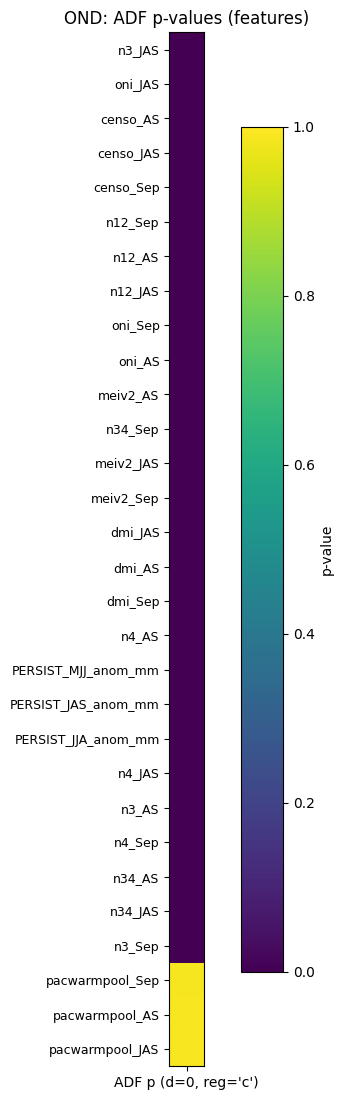

In [18]:
def adf_pvalue_heatmap(results_dict, season: str, d: int = 0, reg: str = "c", topn: int = 40):
    tab = results_dict[(d,reg)]
    # Keep features only (drop target rows)
    mask_feat = ~tab.index.str.startswith(f"{season}_")
    sub = tab.loc[mask_feat, ["pvalue"]].copy()
    sub = sub.sort_values("pvalue").head(topn)

    # Plot
    fig_h = max(4, 0.32*len(sub)+1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    im = ax.imshow(sub.values, vmin=0, vmax=1)  # 0..1 p-values
    ax.set_yticks(range(len(sub))); ax.set_yticklabels(sub.index, fontsize=9)
    ax.set_xticks([0]); ax.set_xticklabels([f"ADF p (d={d}, reg='{reg}')"])
    ax.set_title(f"{season}: ADF p-values (features)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.040, label="p-value")
    fig.tight_layout()
    fig.savefig(os.path.join(REPORT_FIGS, f"ADF_{season}_pvals_heatmap_d{d}_{reg}.png"), dpi=150)
    plt.show()

adf_pvalue_heatmap(OND_adf, "OND", d=0, reg="c", topn=40)
#adf_pvalue_heatmap(MAM_adf, "MAM", d=0, reg="c", topn=40)
